In [1]:
import pdb
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import sklearn.linear_model as linear
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv("../data/interum/top_genres.csv")

In [3]:
def plot_scatter_relationship(data, x, y="Energy"):
    plt.scatter(x=data[x], y=data[y], alpha=0.1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs. {y}")

In [4]:
def plot_distributions(data, x):
    scaler = MinMaxScaler()
    sns.distplot(a=scaler.fit(np.array(data[x]).reshape(-1,1)).transform(np.array(data[x]).reshape(-1,1)), bins=500)
    plt.title(x)
    plt.show()


In [5]:
def adjusted_r_squared(r_squared, num_samples, num_regressors):
    return 1 - ((1-r_squared)*(num_samples - 1) / (num_samples - num_regressors - 1))

## Linear Regression Predicting _Energy_

subset data relevant for predicting energy: 

In [6]:
energy_reg_df = data[[
    "Danceability",
    "Energy",
    "Loudness",
    "Mode",
    "Speechness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
    "Valence",
    "Tempo",
    "Duration_ms",
    'Super_genre',
    'time_signature'
]]
energy_reg_df.head()

,Danceability,Energy,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Super_genre,time_signature
0,0.624,0.857,-6.250,0.0,0.0542,0.020800,0.206000,0.110,0.324,131.926,282920.0,metal,4.0
1,0.517,0.916,-4.933,1.0,0.0559,0.000182,0.001910,0.306,0.444,135.996,300320.0,metal,4.0
2,0.251,0.894,-4.103,0.0,0.0570,0.014400,0.000000,0.123,0.297,114.223,175353.0,metal,4.0
3,0.469,0.743,-5.570,0.0,0.0272,0.002220,0.000111,0.276,0.481,86.953,272292.0,metal,4.0
4,0.487,0.952,-4.429,0.0,0.0613,0.000228,0.000000,0.161,0.329,125.993,237933.0,metal,4.0


Duration appears to benefit from a log transformation, so we add that here

In [7]:
energy_reg_df['log_duration'] = np.log(energy_reg_df.Duration_ms)

/home/allan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Dummy Variables

* Mode - basically major or minor
* time_signature - some integer representing the numerator in the time signature

#### Step 1
cast all categorical variables to strings so we can use pd.get_dummies()

In [20]:
energy_reg_df.Mode = energy_reg_df.Mode.astype(int)
energy_reg_df.time_signature = energy_reg_df.time_signature.astype(int)
energy_reg_df.Mode = energy_reg_df.Mode.astype(str)
energy_reg_df.time_signature = energy_reg_df.time_signature.astype(str)

#### step 2

generate dummy variables using get_dummies()

In [21]:
energy_reg_df=pd.get_dummies(energy_reg_df)
energy_reg_df.head()

,Danceability,Energy,Loudness,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,...,Super_genre_synth,Super_genre_techno,Super_genre_worship,Mode_0,Mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.624,0.857,-6.250,0.0542,0.020800,0.206000,0.110,0.324,131.926,282920.0,...,0,0,0,1,0,0,0,0,1,0
1,0.517,0.916,-4.933,0.0559,0.000182,0.001910,0.306,0.444,135.996,300320.0,...,0,0,0,0,1,0,0,0,1,0
2,0.251,0.894,-4.103,0.0570,0.014400,0.000000,0.123,0.297,114.223,175353.0,...,0,0,0,1,0,0,0,0,1,0
3,0.469,0.743,-5.570,0.0272,0.002220,0.000111,0.276,0.481,86.953,272292.0,...,0,0,0,1,0,0,0,0,1,0
4,0.487,0.952,-4.429,0.0613,0.000228,0.000000,0.161,0.329,125.993,237933.0,...,0,0,0,1,0,0,0,0,1,0


In [32]:
energy_reg_df.rename(columns = {'Super_genre_r&b':'Super_genre_r_and_b'},inplace=True)

In [33]:
energy_reg_df.columns

Index(['Danceability', 'Energy', 'Loudness', 'Speechness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms',
       'log_duration', 'Super_genre_blues', 'Super_genre_classical',
       'Super_genre_country', 'Super_genre_dance', 'Super_genre_disco',
       'Super_genre_edm', 'Super_genre_elect', 'Super_genre_folk',
       'Super_genre_general', 'Super_genre_grunge', 'Super_genre_guitar',
       'Super_genre_hiphop', 'Super_genre_house', 'Super_genre_indie',
       'Super_genre_jazz', 'Super_genre_latin', 'Super_genre_metal',
       'Super_genre_pop', 'Super_genre_punk', 'Super_genre_r_and_b',
       'Super_genre_reggae', 'Super_genre_rock', 'Super_genre_soul',
       'Super_genre_step', 'Super_genre_swing', 'Super_genre_synth',
       'Super_genre_techno', 'Super_genre_worship', 'Mode_0', 'Mode_1',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

## Linear Regression Model

Using energy as our target

In [23]:
# Set dependent and independent variables
y = energy_reg_df.Energy
X = energy_reg_df.drop('Energy', axis=1)
# Get dummy variables and add constant for intercept
X = sm.add_constant(X)

# Split data 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.7)

# fit and summarize your model
model = sm.OLS(y,X).fit()
model.summary()

/home/allan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     8516.
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:58:51   Log-Likelihood:                 75529.
No. Observations:              107973   AIC:                        -1.510e+05
Df Residuals:                  107930   BIC:                        -1.506e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3912      0.013     29.466      0.000       0.365       0.417
Danceability             -0.1682      0.003    -64.554      0.000      -0.173      -0.163
Loudness                  0.0279      0.000    264.884      0.000       0.028       0.028
Speechness                0.2247      0.004     57.103      0.000       0.217       0.232
Acousticness             -0.2756      0.002   -180.811      0.000      -0.279      -0.273
Instrumentalness          0.0723      0.001     59.354      0.000       0.070       0.075
Liveness                  0.1048      0.002     45.262      0.000       0.100       0.109
Valence                   0.1579      0.002     91.481      0.000       0.155       0.161
Tempo                     0.0003   1.31e-05     24.184      0.000       0.000       0.000
Duration_ms           -3.375e-08    5.9e-09     -5.719      0.000   -4.53e-08   -2.22e-08
log_duration              0.0176      0.002      9.032      0.000       0.014       0.021
Super_genre_blues         0.0019      0.003      0.707      0.480      -0.003       0.007
Super_genre_classical     0.0468      0.004     12.396      0.000       0.039       0.054
Super_genre_country       0.0004      0.004      0.095      0.925      -0.007       0.008
Super_genre_dance         0.0583      0.005     12.481      0.000       0.049       0.067
Super_genre_disco        -0.0060      0.008     -0.725      0.468      -0.022       0.010
Super_genre_edm           0.0334      0.007      5.023      0.000       0.020       0.046
Super_genre_elect         0.0328      0.003     12.354      0.000       0.028       0.038
Super_genre_folk         -0.0220      0.002    -11.135      0.000      -0.026      -0.018
Super_genre_general       0.0256      0.001     22.350      0.000       0.023       0.028
Super_genre_grunge        0.0318      0.013      2.456      0.014       0.006       0.057
Super_genre_guitar        0.0157      0.004      4.069      0.000       0.008       0.023
Super_genre_hiphop       -0.0150      0.002     -7.321      0.000      -0.019      -0.011
Super_genre_house         0.0322      0.003     12.645      0.000       0.027       0.037
Super_genre_indie         0.0006      0.002      0.379      0.705      -0.002       0.004
Super_genre_jazz         -0.0015      0.003     -0.588      0.557      -0.006       0.004
Super_genre_latin         0.0113      0.005      2.191      0.028       0.001       0.021
Super_genre_metal         0.0733      0.002     41.396      0.000       0.070       0.077
Super_genre_pop           0.0017      0.002      1.047      0.295      -0.001       0.005
Super_genre_punk          0.0444      0.002     20.761      0.000       0.040       0.049
Super_genre_r&b          -0.0524      0.005    -11.093      0.000      -0.062      -0.043
Super_genre_reggae     

## Variable Selection work

the code below will step through adding variables to our regression and provide the r squared and adjusted r squared scores along the way.  

_Note: depending on the number of variables, this will take a while to run._

In [11]:
# y = energy_reg_df.Energy
# predictors = energy_reg_df.drop('Energy', axis=1)



# linreg = LinearRegression()
# for i in range(1,energy_reg_df.shape[1]):
#     print("\n\n")
#     print('Num Variables', i)
#     selector = RFE(linreg, n_features_to_select=i)

#     selector = selector.fit(X=predictors, y=y)

#     print("Which columns were kept:\t", selector.support_)
# #     print("The coefficients:\t\t", selector.estimator_.coef_)
# #     print("The intercept:\t\t\t", selector.estimator_.intercept_)
#     r_squared = selector.score(predictors,y)
#     adj_r_squared = adjusted_r_squared(r_squared, energy_reg_df.shape[0], i)
    
#     pdb.set_trace()
    
#     print("R Squared\t\t", r_squared)
#     print("Adjusted R Squared\t", adj_r_squared)

## Model Improvement

In [12]:
energy_reg_df.head()

,Danceability,Energy,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,...,Super_genre_punk,Super_genre_r&b,Super_genre_reggae,Super_genre_rock,Super_genre_soul,Super_genre_step,Super_genre_swing,Super_genre_synth,Super_genre_techno,Super_genre_worship
0,0.624,0.857,-6.250,0,0.0542,0.020800,0.206000,0.110,0.324,131.926,...,0,0,0,0,0,0,0,0,0,0
1,0.517,0.916,-4.933,1,0.0559,0.000182,0.001910,0.306,0.444,135.996,...,0,0,0,0,0,0,0,0,0,0
2,0.251,0.894,-4.103,0,0.0570,0.014400,0.000000,0.123,0.297,114.223,...,0,0,0,0,0,0,0,0,0,0
3,0.469,0.743,-5.570,0,0.0272,0.002220,0.000111,0.276,0.481,86.953,...,0,0,0,0,0,0,0,0,0,0
4,0.487,0.952,-4.429,0,0.0613,0.000228,0.000000,0.161,0.329,125.993,...,0,0,0,0,0,0,0,0,0,0


In [38]:
formula = '''~Danceability+Loudness+Speechness+Acousticness+Instrumentalness+Liveness+Valence+Tempo+
            Duration_ms+log_duration+Super_genre_blues+Super_genre_classical+Super_genre_country+
            Super_genre_dance+Super_genre_disco+Super_genre_edm+Super_genre_elect+Super_genre_folk+
            Super_genre_general+Super_genre_grunge+Super_genre_guitar+Super_genre_hiphop+Super_genre_house+
            Super_genre_indie+Super_genre_jazz+Super_genre_latin+Super_genre_metal+Super_genre_pop+
            Super_genre_punk+Super_genre_r_and_b+Super_genre_reggae+Super_genre_rock+Super_genre_soul+
            Super_genre_step+Super_genre_swing+Super_genre_synth+Super_genre_techno+Super_genre_worship+
            Mode_0+Mode_1+time_signature_0+time_signature_1+time_signature_3+time_signature_4+time_signature_5'''

In [39]:
model = 'Energy' + formula

In [41]:
result = Resampling.bootstrap_linear_regression(model,energy_reg_df)

In [42]:
print(Resampling.describe_bootstrap_lr(result))

Model: Energy~Danceability+Loudness+Speechness+Acousticness+Instrumentalness+Liveness+Valence+Tempo+
            Duration_ms+log_duration+Super_genre_blues+Super_genre_classical+Super_genre_country+
            Super_genre_dance+Super_genre_disco+Super_genre_edm+Super_genre_elect+Super_genre_folk+
            Super_genre_general+Super_genre_grunge+Super_genre_guitar+Super_genre_hiphop+Super_genre_house+
            Super_genre_indie+Super_genre_jazz+Super_genre_latin+Super_genre_metal+Super_genre_pop+
            Super_genre_punk+Super_genre_r_and_b+Super_genre_reggae+Super_genre_rock+Super_genre_soul+
            Super_genre_step+Super_genre_swing+Super_genre_synth+Super_genre_techno+Super_genre_worship+
            Mode_0+Mode_1+time_signature_0+time_signature_1+time_signature_3+time_signature_4+time_signature_5
---------------------  ----------  -----  -----------  ----------
                                          95% BCI
Coefficients                       Mean   Lo           Hi


In [45]:
energy_reg_df.describe()

,Danceability,Energy,Loudness,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,...,Super_genre_synth,Super_genre_techno,Super_genre_worship,Mode_0,Mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
count,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,1.079730e+05,...,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000
mean,0.550963,0.642299,-8.671973,0.084604,0.279791,0.241153,0.194109,0.465391,121.812796,2.549906e+05,...,0.001741,0.013763,0.010530,0.382512,0.617488,0.000296,0.009067,0.087401,0.887852,0.015383
std,0.184471,0.249686,4.916737,0.102570,0.328708,0.358198,0.164054,0.267500,29.113351,1.285168e+05,...,0.041691,0.116505,0.102077,0.486003,0.486003,0.017213,0.094789,0.282424,0.315550,0.123073
min,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.576000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.427000,0.477000,-10.570000,0.036100,0.008130,0.000002,0.095100,0.239000,99.946000,1.909600e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.564000,0.683000,-7.479000,0.048500,0.114000,0.001990,0.125000,0.453000,120.970000,2.299600e+05,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.691000,0.851000,-5.397000,0.083900,0.513000,0.557000,0.247000,0.681000,139.951000,2.878930e+05,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.988000,1.000000,5.056000,0.966000,0.996000,0.999000,1.000000,1.000000,248.066000,5.949886e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
energy_reg_df.columns

Index(['Danceability', 'Energy', 'Loudness', 'Speechness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms',
       'log_duration', 'Super_genre_blues', 'Super_genre_classical',
       'Super_genre_country', 'Super_genre_dance', 'Super_genre_disco',
       'Super_genre_edm', 'Super_genre_elect', 'Super_genre_folk',
       'Super_genre_general', 'Super_genre_grunge', 'Super_genre_guitar',
       'Super_genre_hiphop', 'Super_genre_house', 'Super_genre_indie',
       'Super_genre_jazz', 'Super_genre_latin', 'Super_genre_metal',
       'Super_genre_pop', 'Super_genre_punk', 'Super_genre_r_and_b',
       'Super_genre_reggae', 'Super_genre_rock', 'Super_genre_soul',
       'Super_genre_step', 'Super_genre_swing', 'Super_genre_synth',
       'Super_genre_techno', 'Super_genre_worship', 'Mode_0', 'Mode_1',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

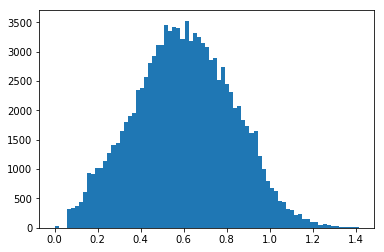

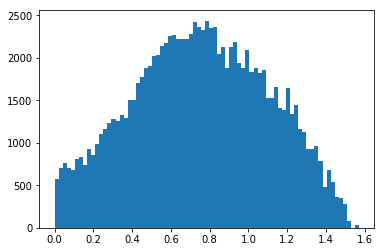

In [72]:
nums_1=['Danceability', 'Energy']
for num in nums_1:
    plt.hist(np.arcsin(energy_reg_df[num]),bins = 75)
    plt.show()